In [460]:
import numpy as np
import pandas as pd


In [461]:
import os

In [462]:
base_data_dir = '/kaggle/input/alzheimer/alzheimer'
train_base_dir = f'{base_data_dir}/train'
test_base_dir = f'{base_data_dir}/test'

In [463]:
class_distributions = {}
classes = os.listdir(train_base_dir)

In [464]:
for class_name in classes:
    class_distributions[class_name] = len(os.listdir(f'{train_base_dir}/{class_name}'))

In [465]:
class_distributions

{'ModerateDemented': 52,
 'NonDemented': 2560,
 'VeryMildDemented': 1792,
 'MildDemented': 717}

In [466]:
from matplotlib import pyplot as plt

#### Distribution of classes in the train dataset

([0, 1, 2, 3],
 [Text(0, 0, 'ModerateDemented'),
  Text(1, 0, 'NonDemented'),
  Text(2, 0, 'VeryMildDemented'),
  Text(3, 0, 'MildDemented')])

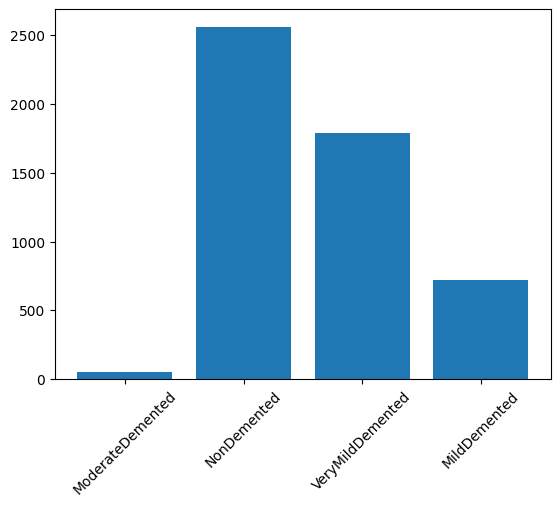

In [467]:
plt.bar(classes, class_distributions.values())
plt.xticks(rotation=45)

In [468]:
from PIL import Image

In [469]:
def get_image_dimensions(image_path):
    image = Image.open(image_path)
    return image.width, image.height

In [470]:
from tqdm import tqdm

In [471]:
class_dimensions_distributions = {
    'width': [],
    'height': [],
    'class': []
}

In [472]:
for class_name in classes:
    for image_name in tqdm(os.listdir(f'{train_base_dir}/{class_name}')):
        image_path = f'{train_base_dir}/{class_name}/{image_name}'
        image_width, image_height = get_image_dimensions(image_path)
        class_dimensions_distributions['width'].append(image_width)
        class_dimensions_distributions['height'].append(image_height)
        class_dimensions_distributions['class'].append(class_name)

100%|██████████| 717/717 [00:01<00:00, 509.39it/s]


In [473]:
dimensions_df = pd.DataFrame(class_dimensions_distributions)
dim_df = pd.DataFrame(class_dimensions_distributions)

In [474]:
dimensions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5121 entries, 0 to 5120
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   width   5121 non-null   int64 
 1   height  5121 non-null   int64 
 2   class   5121 non-null   object
dtypes: int64(2), object(1)
memory usage: 120.1+ KB


In [475]:
dimensions_df.describe()

,width,height
count,5121.0,5121.0
mean,176.0,208.0
std,0.0,0.0
min,176.0,208.0
25%,176.0,208.0
50%,176.0,208.0
75%,176.0,208.0
max,176.0,208.0


#### Distribution of photos' dimensions

In [476]:
dimensions_df['width'].value_counts(), dimensions_df['height'].value_counts()

(width
 176    5121
 Name: count, dtype: int64,
 height
 208    5121
 Name: count, dtype: int64)

In [477]:
dimensions_df.shape

(5121, 3)

In [478]:
def image_to_numpy(image_path):
    image = Image.open(image_path)
    return np.array(image)

In [479]:
# setting tensor to store all images' pixels
images = np.empty((5121, 208, 176))
class_to_idx = {}
for i in range(len(classes)):
    class_to_idx[classes[i]] = i
images_labels = np.empty(5121)

In [480]:
image_idx = 0
for class_name in classes:
    for image_name in tqdm(os.listdir(f'{train_base_dir}/{class_name}')):
        image_path = f'{train_base_dir}/{class_name}/{image_name}'
        images[image_idx] = image_to_numpy(image_path)
        images_labels[image_idx] = class_to_idx[class_name]
        image_idx += 1

100%|██████████| 717/717 [00:00<00:00, 1050.19it/s]


In [481]:
import seaborn as sns

#### Displaying heatmap for each class - whiter is weaker density

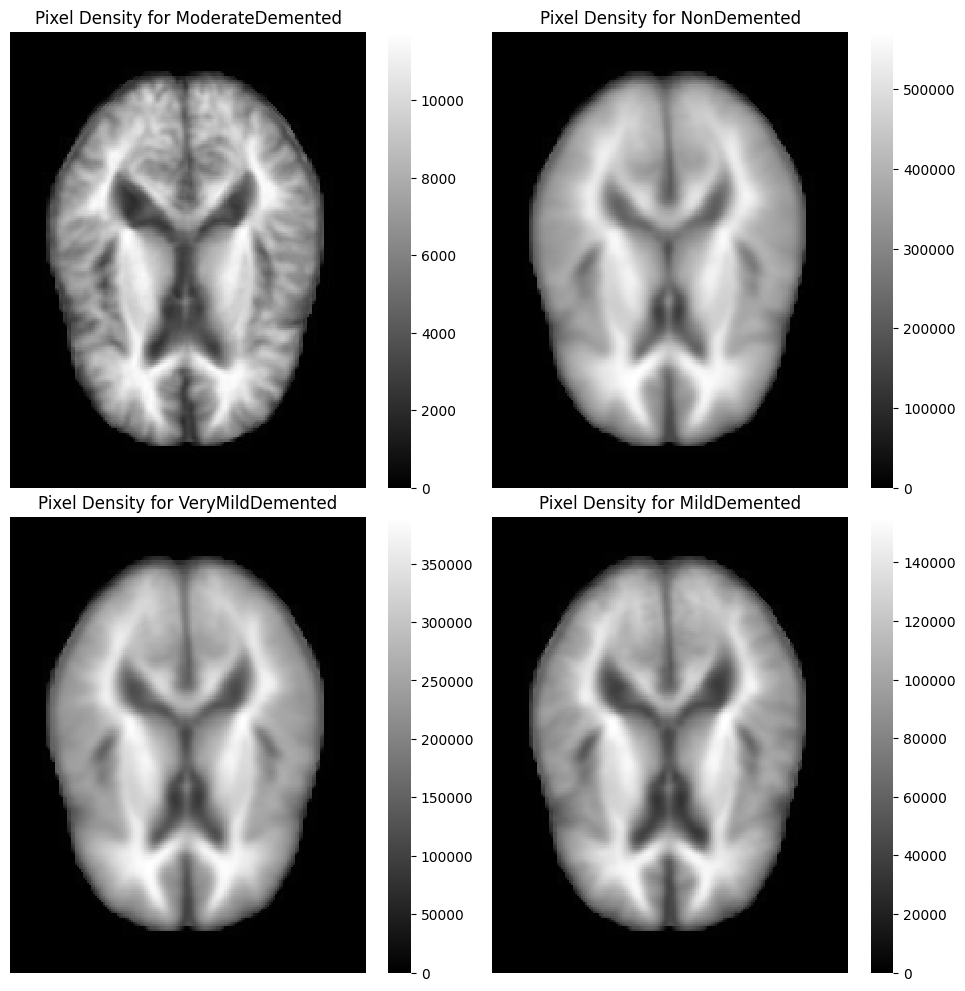

In [482]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10), sharey=True, sharex=True)
fig.tight_layout()

for i in range(len(classes)):
    ax = axes[i//2, i%2]
    class_images = images[np.where(images_labels == i)]
    heatmap = np.sum(class_images, axis=0)
    sns.heatmap(heatmap, ax=ax, cmap='gray')
    ax.set_title(f'Pixel Density for {classes[i]}')
    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_visible(False)

#### Drop all empty pixels to reduce dimensions

In [483]:
# get leftmost non empty pixel
non_empty_pixels = np.where(images > 0)[1:]

In [484]:
non_empty_pixels

(array([ 16,  16,  16, ..., 191, 191, 191]),
 array([ 88,  89,  90, ..., 117, 118, 119]))

In [485]:
uppermost_pixel = np.min(non_empty_pixels[0])
bottommost_pixel = np.max(non_empty_pixels[0])
leftmost_pixel = np.min(non_empty_pixels[1])
rightmost_pixel = np.max(non_empty_pixels[1])

In [486]:
# top left
leftmost_pixel, uppermost_pixel

(16, 16)

In [487]:
# bottom right
rightmost_pixel, bottommost_pixel

(159, 191)

In [488]:
# dropping
images = images[:, uppermost_pixel:bottommost_pixel+1, leftmost_pixel:rightmost_pixel+1]

In [489]:
images.shape

(5121, 176, 144)

In [490]:
df = pd.DataFrame(images.reshape(images.shape[0], -1))

In [491]:
df.shape

(5121, 25344)

In [492]:
# number of reduced dimensions
208 * 176 - 25344

11264

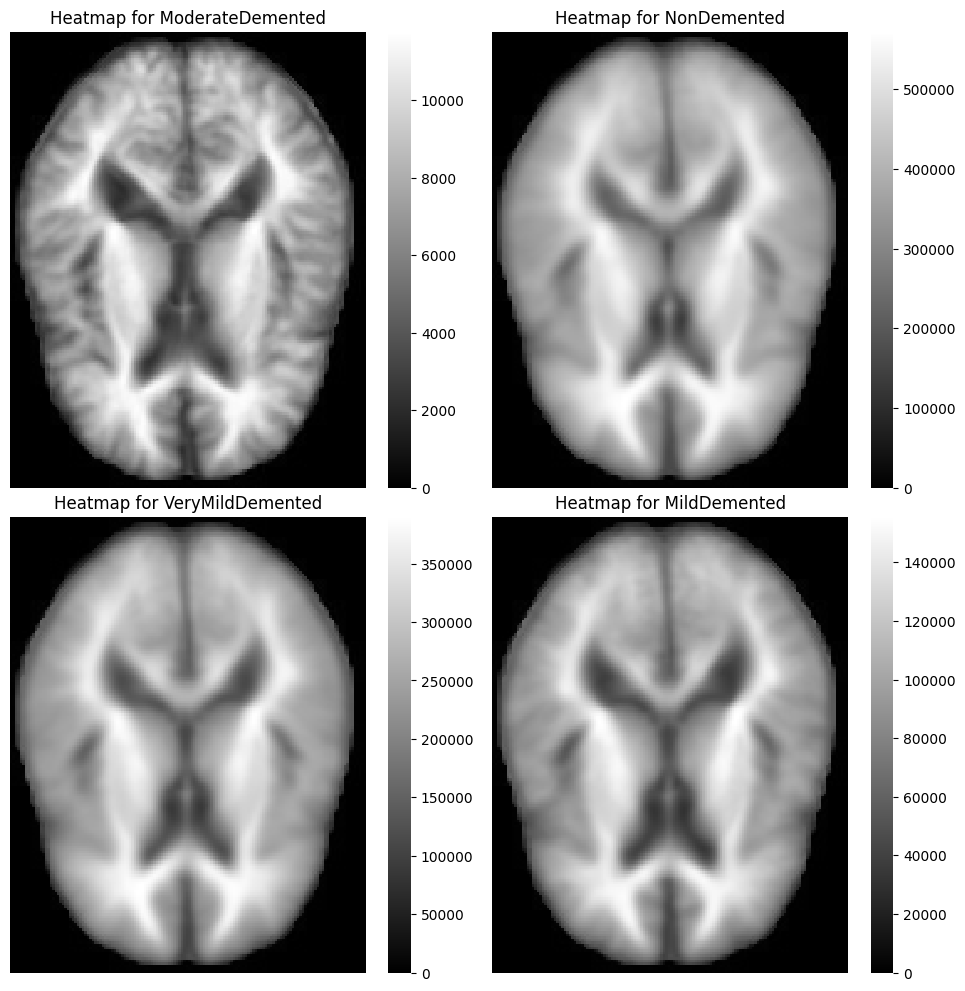

In [493]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10), sharey=True, sharex=True)
fig.tight_layout()

for i in range(len(classes)):
    ax = axes[i//2, i%2]
    class_images = images[np.where(images_labels == i)]
    heatmap = np.sum(class_images, axis=0)
    sns.heatmap(heatmap, ax=ax, cmap='gray')
    ax.set_title(f'Heatmap for {classes[i]}')
    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_visible(False)

#### NOT normalizing the images as the decoding process is less successful when dealing with a small range of numbers

In [494]:
# images = images / images.max()

#### Showing distribution of several pixels

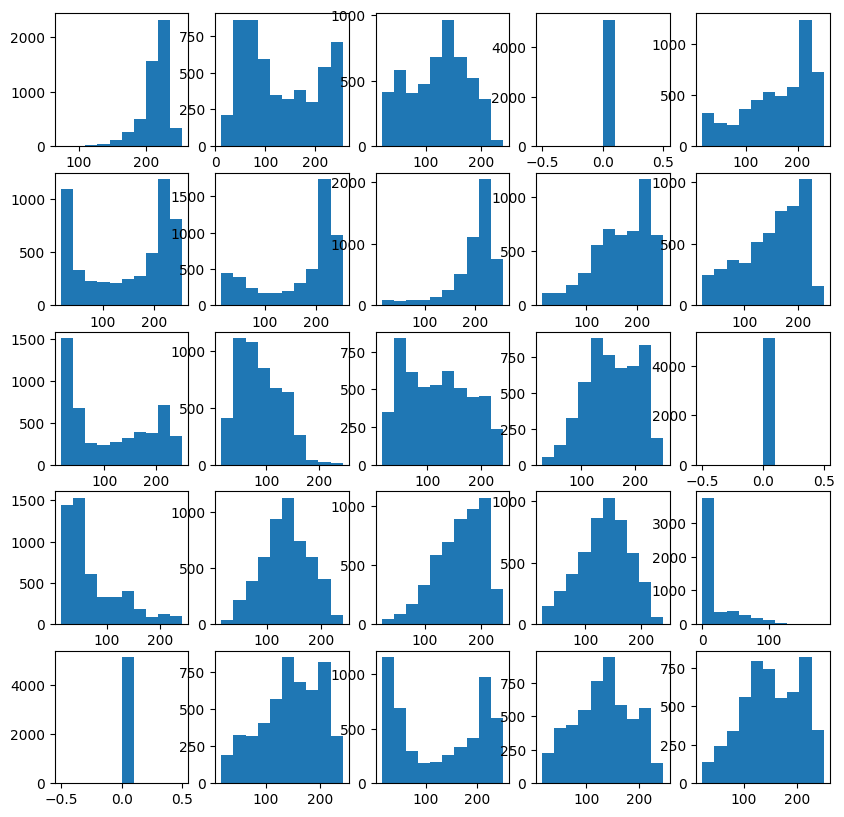

In [495]:
fig, axes = plt.subplots(5, 5, figsize=(10, 10))

random_pixels = np.random.default_rng().choice(176 * 144, size=25, replace=False)

for i in range(25):
    ax = axes[i // 5, i % 5]
    ax.hist(images[:, random_pixels[i]//176, random_pixels[i]%144])

### Filters

In [496]:
import scipy as sp

In [497]:
def plot_transformed_and_original(transformed_images):
    # plot
    fig = plt.figure(constrained_layout=True, figsize=(18, 10))
    subfigs = fig.subfigures(2, 2)

    for class_idx, subfig in enumerate(subfigs.flat):
        subfig.suptitle(classes[class_idx])
        axes = subfig.subplots(1, 2)

        blurred_images = transformed_images[np.where(images_labels == class_idx)]
        blurred_heatmap = np.sum(blurred_images, axis=0)
        sns.heatmap(blurred_heatmap, ax=axes[0], cmap='gray')
        axes[0].set_title('Blurred')
        axes[0].get_yaxis().set_visible(False)
        axes[0].get_xaxis().set_visible(False)

        original_images = images[np.where(images_labels == class_idx)]
        original_heatmap = np.sum(original_images, axis=0)
        sns.heatmap(original_heatmap, ax=axes[1], cmap='gray')
        axes[1].set_title('Original')
        axes[1].get_yaxis().set_visible(False)
        axes[1].get_xaxis().set_visible(False)

In [498]:
def apply_filter(filter_func, **kwargs):
    filtered_images = filter_func(images, **kwargs)
    plot_transformed_and_original(filtered_images)

#### Applying median filter with a kernel size of 3x3

In [499]:
# apply_filter(sp.ndimage.median_filter, size=3)

#### Applying max filter with same kernel

In [500]:
# apply_filter(sp.ndimage.maximum_filter, size=3)

#### Minimum filter

In [501]:
# apply_filter(sp.ndimage.minimum_filter, size=3)

#### Sobel filter

In [502]:
# sobel_images_x = sp.ndimage.sobel(images, axis=1)
# sobel_images_y = sp.ndimage.sobel(images, axis=2)
# sobel_images = np.sqrt(sobel_images_x ** 2 + sobel_images_y ** 2)

In [503]:
# plot_transformed_and_original(sobel_images)

In [504]:
# turning off pixels smaller than their image's mean
# greater_than_mean = np.where(images > images.mean(axis=0), 0, images)
# plot_transformed_and_original(greater_than_mean)

### Data Augmentation

#### Training a variational autoencoder for augmenting randomized corrupted data to create new samples
##### Inspired from the following article: https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73

In [505]:
import torch
from torch import nn

In [506]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

#### Preparing data for PyTorch

In [507]:
class AlzheimerDataset(torch.utils.data.Dataset):
    def __init__(self, np_images, np_labels, transform=None, target_transform=None):
        # self.X = torch.from_numpy(np_images).to(torch.float32)
        self.X = torch.from_numpy(np_images).to(torch.float32).unsqueeze(dim=1) # adding the single channel
        # self.y = torch.from_numpy(np_labels).to(torch.float32)
        self.y = torch.from_numpy(np_labels)
        
        self.transform = transform
        self.target_transform = target_transform
        
        self.len = len(self.X)
        
    def __len__(self):
        return self.len
    
    def __getitem__(self, idx):
        images = self.X[idx]
        labels = self.y[idx]
        if self.transform:
            images = self.transform(images)
        if self.target_transform:
            labels = self.target_transform(labels)
        
        return images, labels

In [508]:
alzheimer_dataset = AlzheimerDataset(images, images_labels)

In [509]:
dataloader = torch.utils.data.DataLoader(alzheimer_dataset, batch_size=256, shuffle=True)

#### Defining encoder and decoder

In [510]:
class ConvEncoder(nn.Module):
    def __init__(self, in_channels, encoded_dim, initial_out_channels=3):
        super().__init__()
        
        # non parameterized functionality
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        
        out_channels = initial_out_channels
        
        # initial layers
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=(5, 5),
                               stride=(2, 2), padding=(3, 3), bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.max_indices = None
        self.maxpool = nn.MaxPool2d(kernel_size=(3, 3), stride=(2, 2), 
                                    padding=(1, 1), ceil_mode=False, return_indices=True)
        
        # first residual block
        self.block0 = nn.Sequential(
            # bias is false as we have a bias in the BN layer
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
#             nn.Dropout2d(0.25),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
        
        out_channels *= 2
        
        # down sampling
        self.down_sample0 = nn.Sequential(
            nn.Conv2d(out_channels // 2, out_channels, 3, padding=1, stride=2, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
#             nn.Dropout2d(0.25),
        )
        
        self.block1 = nn.Sequential(
            # bias is false as we have a bias in the BN layer
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
#             nn.Dropout2d(0.25),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
        
        out_channels *= 2
        
        self.down_sample1 = nn.Sequential(
            nn.Conv2d(out_channels // 2, out_channels, 3, padding=1, stride=2, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
#             nn.Dropout2d(0.25)
        )
        
        '''
        self.block2 = nn.Sequential(
            # bias is false as we have a bias in the BN layer
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
#             nn.Dropout2d(0.25),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
        
        out_channels *= 2
        
        self.down_sample2 = nn.Sequential(
            nn.Conv2d(out_channels // 2, out_channels, 3, padding=1, stride=2, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
#             nn.Dropout2d(0.25)
        )
        '''
        
        self.linear = nn.Linear(in_features=1440, out_features=encoded_dim, bias=True)
    
#         self.encoded_mean = nn.Linear(3840, out_features=encoded_dim, bias=True)
#         self.encoded_log_variance = nn.Linear(3840, out_features=encoded_dim, bias=True)
        
        self.final_out_channels = out_channels
        
            
    def forward(self, X):
        X0 = self.conv1(X)
        X0 = self.bn1(X0)
        X0 = self.relu(X0)
        X0, self.max_indices = self.maxpool(X0)
        
        # residual block
        Y0_ = self.block0(X0)
        Y0_0 = X0 + Y0_
        Y0 = self.down_sample0(Y0_0)
        Y0 = self.relu(Y0)
        
        Y1_ = self.block1(Y0)
        Y1_1 = Y0 + Y1_
        Y1 = self.down_sample1(Y1_1)
        Y1 = self.relu(Y1)
        
#         Y2_ = self.block2(Y1)
#         Y2_2 = Y1 + Y2_
#         Y2 = self.down_sample2(Y2_2)
#         Y2 = self.relu(Y2)
        
#         print(Y2.shape)
#         print(Y1.shape)
        Y = self.flatten(Y1)
        Y = self.linear(Y.squeeze())
        
        return Y
        
#         encoded_mean = self.encoded_mean(Y)
#         encoded_log_var = self.encoded_log_variance(Y)
#         epsilon = torch.randn_like(encoded_mean).to(device=device, dtype=torch.float32)
#         encoded = encoded_mean + epsilon * torch.exp(encoded_log_var/2).to(device=device, dtype=torch.float32)
        
# #         print(f'encoded: {encoded.shape}')
        
#         return encoded, encoded_mean, encoded_log_var

In [575]:
class ConvDecoder(nn.Module):
    def __init__(self, encoded_dim, upsampling, initial_out_channels):
        super().__init__()
        
        self.initial_out_channels = initial_out_channels
        out_channels = initial_out_channels
        
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.zero_padding = nn.ZeroPad2d(2)
        
        self.linear = nn.Linear(in_features=encoded_dim, out_features=1440, bias=True)
        
        # reshape to image shape before passing through this block
        '''
        self.up_sample0 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=out_channels, out_channels=out_channels // 2,
                               kernel_size=3, padding=1, stride=2, bias=False),
            nn.BatchNorm2d(out_channels // 2),
            nn.ReLU(),
#             nn.Dropout2d(0.25),
        )
            
        out_channels = out_channels // 2
        
        self.block0 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=out_channels, out_channels=out_channels,
                   kernel_size=3, padding=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
#             nn.Dropout2d(0.25),
            nn.ConvTranspose2d(in_channels=out_channels, out_channels=out_channels,
                               kernel_size=3, padding=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
        '''
        
        self.up_sample1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=out_channels, out_channels=out_channels // 2,
                               kernel_size=3, padding=1, stride=2, bias=False),
            nn.BatchNorm2d(out_channels // 2),
            nn.ReLU(),
#             nn.Dropout2d(0.25),
        )
        
        out_channels = out_channels // 2    
        
        self.block1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=out_channels, out_channels=out_channels,
                   kernel_size=3, padding=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
#             nn.Dropout2d(0.25),
            nn.ConvTranspose2d(in_channels=out_channels, out_channels=out_channels,
                               kernel_size=3, padding=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
        
        self.up_sample2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=out_channels, out_channels=out_channels // 2,
                               kernel_size=3, padding=1, stride=2, bias=False),
            nn.BatchNorm2d(out_channels // 2),
            nn.ReLU(),
#             nn.Dropout2d(0.25),
        )
        
        out_channels = out_channels // 2
        
        self.block2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=out_channels, out_channels=out_channels,
                   kernel_size=3, padding=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
#             nn.Dropout2d(0.25),
            nn.ConvTranspose2d(in_channels=out_channels, out_channels=out_channels,
                               kernel_size=3, padding=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
        
        self.max_indices = None
        self.max_unpool = nn.MaxUnpool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.conv_transpose1 = nn.ConvTranspose2d(out_channels, 1, kernel_size=(5, 5),
                                                  stride=(2, 2), padding=(2, 2), bias=False)
        self.bn1 = nn.BatchNorm2d(1)
        
        
    def set_max_indices(self, max_indices):
        self.max_indices = max_indices

    def forward(self, X):
#         print(f'X: {X.shape}')
        X0 = self.linear(X)
#         print(f'X0: {X0.shape}')
        # reshaping to (batch, channels, pixels) shape
        X0 = X0.reshape(-1, self.initial_out_channels, 12, 10)
        X0 = self.relu(X0)
        
#         print(f'X0: {X0.shape}')
        
#         Y0_ = self.up_sample0(X0)
#         Y0_0 = self.block0(Y0_)
#         Y0 = Y0_ + Y0_0 
#         Y0 = self.relu(Y0)
        
#         print(f'Y0: {Y0.shape}')
        
        Y1_ = self.up_sample1(X0)
        Y1_1 = self.block1(Y1_)
        Y1 = Y1_ + Y1_1
        Y1 = self.relu(Y1)
        
#         print(f'Y1: {Y1.shape}')
        
        Y2_ = self.up_sample2(Y1)
        Y2_2 = self.block2(Y2_)
        Y2 = Y2_ + Y2_2
        Y2 = self.relu(Y2)
        
#         Y2 = self.zero_padding(Y2)
#         print(Y2.shape)
        
        Y = self.max_unpool(Y2, self.max_indices)
        Y = self.conv_transpose1(Y)
        Y = self.bn1(Y)
        Y = self.relu(Y)
        # remove last row and column in the image
        Y = Y[..., :-1, :-1]
        # use sigmoid only if pixel values are in [0, 1] range
#         Y = self.sigmoid(Y)
        
        # print(Y.shape)
        
        return Y

In [576]:
def kl_divergence_loss(mean, log_var):
    kl_sum = torch.sum(1 + log_var - mean**2 - torch.exp(log_var), dim=1)
    return -0.5 * kl_sum.mean(dim=0)

In [577]:
class AutoEncoder(nn.Module):
    def __init__(self, in_channels, encoded_dim, upsampling=False):
        super().__init__()
        # latent space is encoded_dim dimensions
        self.encoder = ConvEncoder(in_channels=in_channels, encoded_dim=encoded_dim)
        self.decoder = ConvDecoder(encoded_dim=encoded_dim, upsampling=upsampling,
                                   initial_out_channels=self.encoder.final_out_channels)

    def forward(self, X):
#         encoded, encoded_mean, encoded_log_var = self.encoder(X)
        encoded = self.encoder(X)
        self.decoder.set_max_indices(self.encoder.max_indices)
        decoded = self.decoder(encoded)
        
        return decoded
#         return encoded, encoded_mean, encoded_log_var, decoded

In [646]:
encoded_dim = 2
autoencoder = AutoEncoder(in_channels=1, encoded_dim=encoded_dim, upsampling=False)
encoder = autoencoder.encoder
decoder = autoencoder.decoder

In [647]:
sum(p.numel() for p in autoencoder.parameters())

10726

In [648]:
lr = 0.01
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=lr, betas=(0.9, 0.999))
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)
mse = nn.MSELoss()

decoding_weight = 1

In [649]:
autoencoder.to(device)

AutoEncoder(
  (encoder): ConvEncoder(
    (relu): ReLU()
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (conv1): Conv2d(1, 3, kernel_size=(5, 5), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (maxpool): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=1, ceil_mode=False)
    (block0): Sequential(
      (0): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
    (down_sample0): Sequential(
      (0): Conv2d(3, 6, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track

In [650]:
epochs = 50
overall_losses = torch.zeros(epochs)
kl_divergence_losses = torch.zeros(epochs)
mse_losses = torch.zeros(epochs)

In [651]:
for epoch in tqdm(range(epochs)):
    autoencoder.train()
    for batch_idx, (batch_X, _) in enumerate(dataloader):
        batch_X = batch_X.to(device=device)
        optimizer.zero_grad()
#         batch_encoded_output, batch_encoded_mean, batch_encoded_log_var, batch_decoded_output = autoencoder(batch_X)
        batch_decoded_output = autoencoder(batch_X)
        
        batch_mse_loss = mse(batch_decoded_output, batch_X)
        batch_loss = batch_mse_loss
#         batch_kl_divergence_loss = kl_divergence_loss(batch_encoded_mean, batch_encoded_log_var)
#         batch_loss = decoding_weight * batch_mse_loss + batch_kl_divergence_loss
    
        batch_loss.backward()
        optimizer.step()
        scheduler.step()
        
    with torch.no_grad():
        # print('Evaluating model...')
        autoencoder.eval()
#         encoded_output, encoded_mean, encoded_log_var, decoded_output = autoencoder(alzheimer_dataset.X.to(device))
        decoded_output = autoencoder(alzheimer_dataset.X.to(device))
        mse_loss_value = mse(decoded_output, alzheimer_dataset.X.to(device))
        output_loss = mse_loss_value
#         kl_divergence_loss_value = kl_divergence_loss(encoded_mean, encoded_log_var)
#         output_loss = decoding_weight * mse_loss_value + kl_divergence_loss_value
        
        overall_losses[epoch] = output_loss.item()
#         kl_divergence_losses[epoch] = kl_divergence_loss_value.item()
#         mse_losses[epoch] = mse_loss_value.item()

100%|██████████| 50/50 [01:16<00:00,  1.53s/it]


In [652]:
autoencoder.eval()

AutoEncoder(
  (encoder): ConvEncoder(
    (relu): ReLU()
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (conv1): Conv2d(1, 3, kernel_size=(5, 5), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (maxpool): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=1, ceil_mode=False)
    (block0): Sequential(
      (0): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
    (down_sample0): Sequential(
      (0): Conv2d(3, 6, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track

Text(0.5, 1.0, 'MSE Loss')

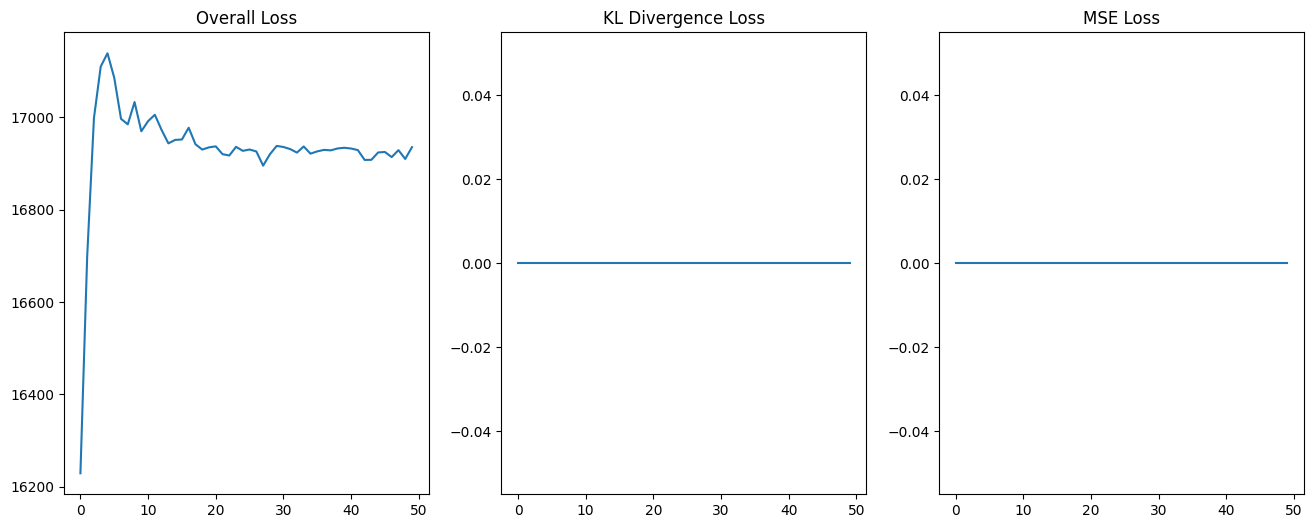

In [653]:
fig, axes = plt.subplots(1, 3, figsize=(16, 6))
axes[0].plot(overall_losses.cpu())
axes[0].set_title('Overall Loss')

axes[1].plot(kl_divergence_losses.cpu())
axes[1].set_title('KL Divergence Loss')

axes[2].plot(mse_losses.cpu())
axes[2].set_title('MSE Loss')
# plt.plot(losses.cpu())

In [654]:
image_to_generate = images[1]
# getting a generated image from the original
with torch.no_grad():
    # expanding the channel
    original_batched_image = np.expand_dims(image_to_generate, axis=0)
    # expanding batch
    original_batched_image = np.expand_dims(original_batched_image, axis=0)
    generated_image = autoencoder(torch.from_numpy(original_batched_image) \
                                  .to(device=device, dtype=torch.float32))
    generated_image = generated_image.flatten(start_dim=0, end_dim=2)
    print(generated_image.shape)

torch.Size([176, 144])


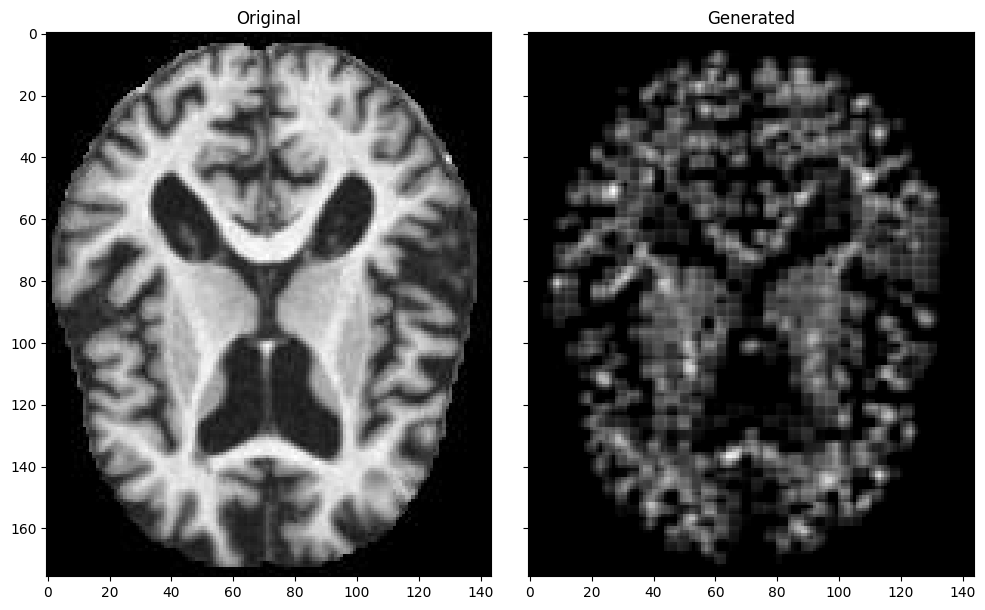

In [655]:
fig, axes = plt.subplots(1, 2, figsize=(10, 10), sharey=True, sharex=True)
fig.tight_layout()

axes[0].set_title('Original')
axes[0].imshow(image_to_generate, cmap='gray')
axes[1].set_title('Generated')
axes[1].imshow(generated_image.cpu(), cmap='gray')

In [656]:
single_channel_images = np.expand_dims(images, axis=1)

with torch.no_grad():
    encoded_images = encoder(torch.from_numpy(single_channel_images).to(device=device, dtype=torch.float32))
    encoded_images = encoded_images.cpu()

In [657]:
encoded_images.shape

torch.Size([5121, 2])

In [658]:
with torch.no_grad():
    decoded_images = autoencoder(torch.from_numpy(single_channel_images).to(device=device, dtype=torch.float32))
    decoded_images = decoded_images.cpu()

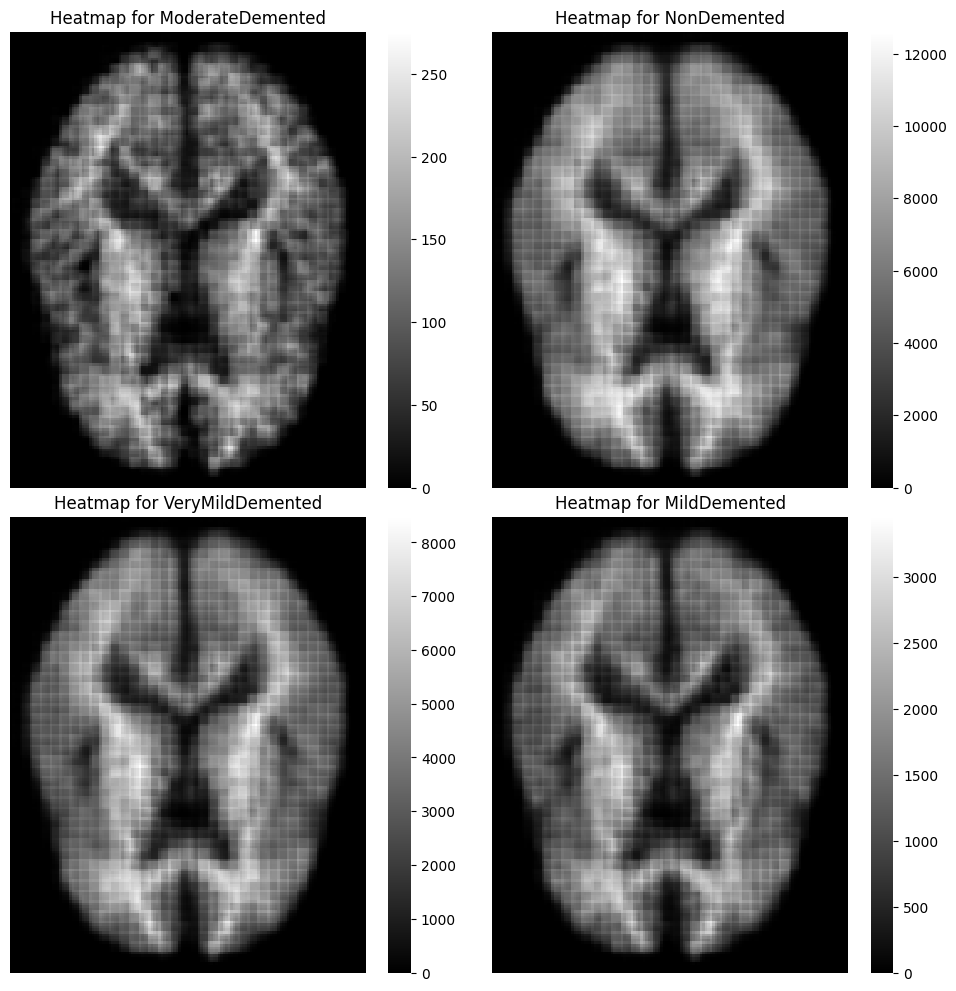

In [659]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10), sharey=True, sharex=True)
fig.tight_layout()

for i in range(len(classes)):
    ax = axes[i//2, i%2]
    class_images = decoded_images.squeeze().detach().numpy()[np.where(images_labels == i)]
    heatmap = np.sum(class_images, axis=0)
    sns.heatmap(heatmap, ax=ax, cmap='gray')
    ax.set_title(f'Heatmap for {classes[i]}')
    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_visible(False)

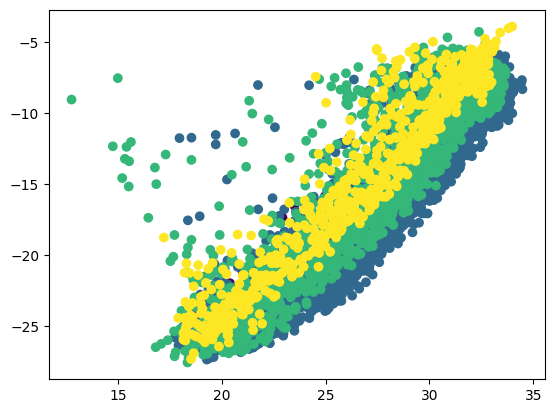

In [660]:
plt.scatter(encoded_images[:, 0], encoded_images[:, 1], c=images_labels)

In [529]:
def generate_image(encoded_dim):
    encoded_min = encoded_images.min()
    encoded_max = encoded_images.max()
    coordinates = encoded_min + np.random.default_rng() \
        .choice(int((encoded_max - encoded_min).item()),
                size=encoded_dim)
    coordinates = np.expand_dims(coordinates, axis=0)
    coordinates = np.expand_dims(coordinates, axis=0)
    return torch.tensor(torch.from_numpy(coordinates).to(device=device, dtype=torch.float32).detach())